# Regression: End-to-End Workflow Exploration

**Task**: Predict the median house values in California districts.

## Get/Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter='data')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

## Explore the Dataset

In [2]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Notice the `ocean_proximity` column contains non-numerical data. This means it is likely a categorical attribute and we can explore the category types.

In [3]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Lets explore the dataset's structure

In [4]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice `total_bedrooms` contains missing/null values. This will be handled later in the **Data Imputation** step.

In [5]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


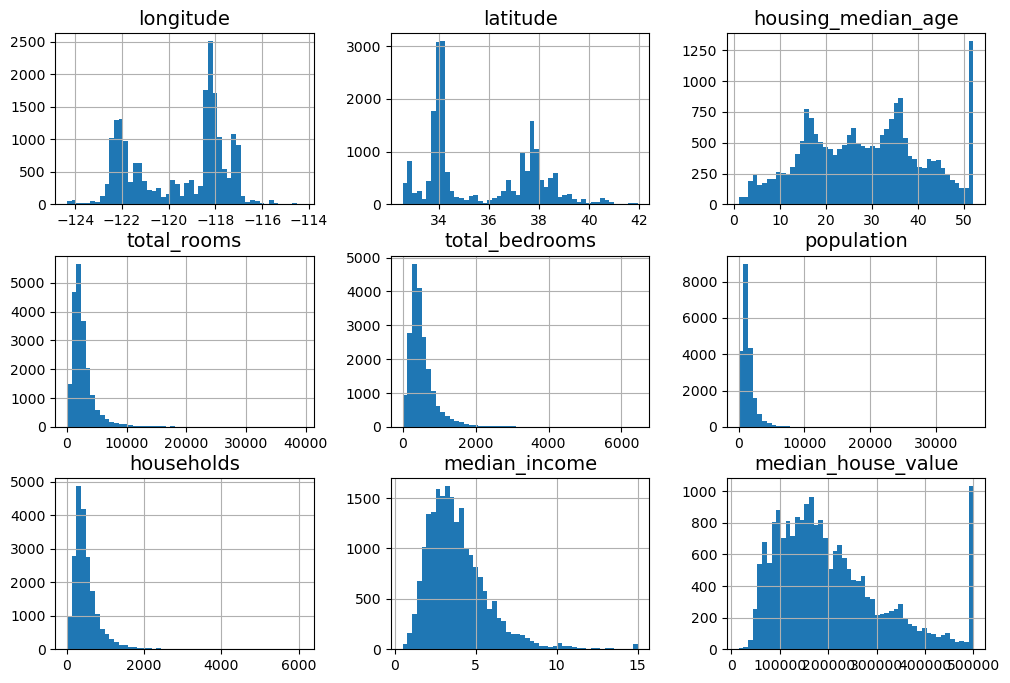

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing_full.hist(bins=50, figsize=(12, 8))
plt.show()

**IMPORTANT**: Many histograms are ***skewed right*** (positively skewed). This _impacts the ability_ of some machine learning algorithms to detect patterns. Specifically, **linear models** may have trouble with ***generalization*** and ***predictions***. Ideally, it's best to evaluate performance then transform the data and reevaluate performance to see if improvements were made.

# Visualizing Geographical Data

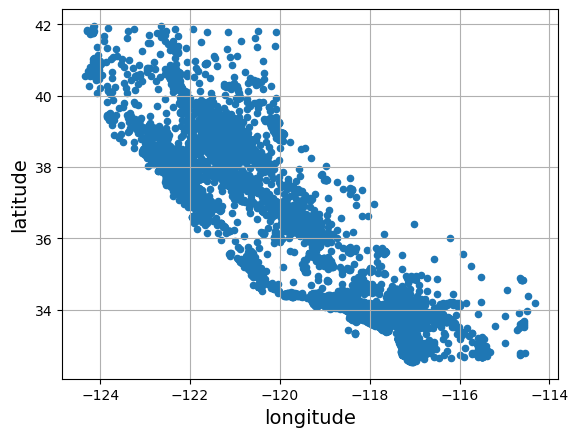

In [7]:
housing_full.plot(kind="scatter", x="longitude", y="latitude", grid=True)

plt.show()

Making the data points transparent makes it easier to visualize where there is high density of data points. You can clearly see the high density areas, namely the Bay Area around Los Angeles, San Diego, etc.

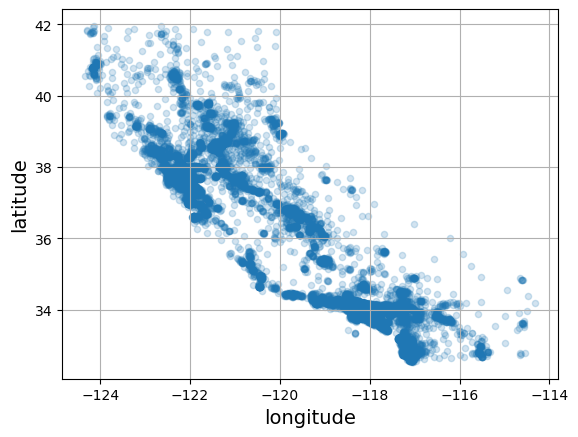

In [8]:
# add transparency to the data points
housing_full.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

plt.show()

This image tells you that the housing prices are very much related to
the location (e.g., close to the ocean) and to the population density.

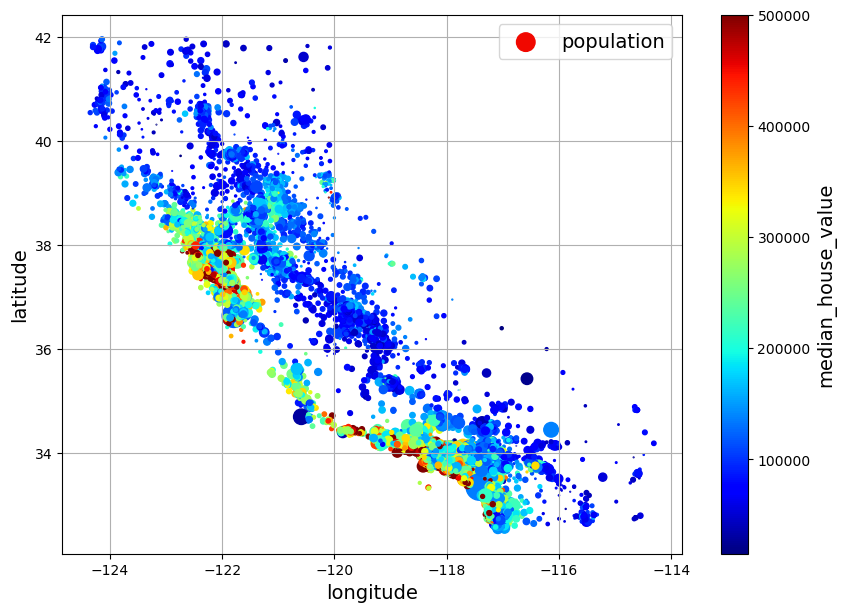

In [9]:
housing_full.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s=housing_full["population"] / 100, label="population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False, figsize=(10, 7))

plt.show()

This next cell just a beautified version of the previous figure, with an image of California added to the background for more realism.

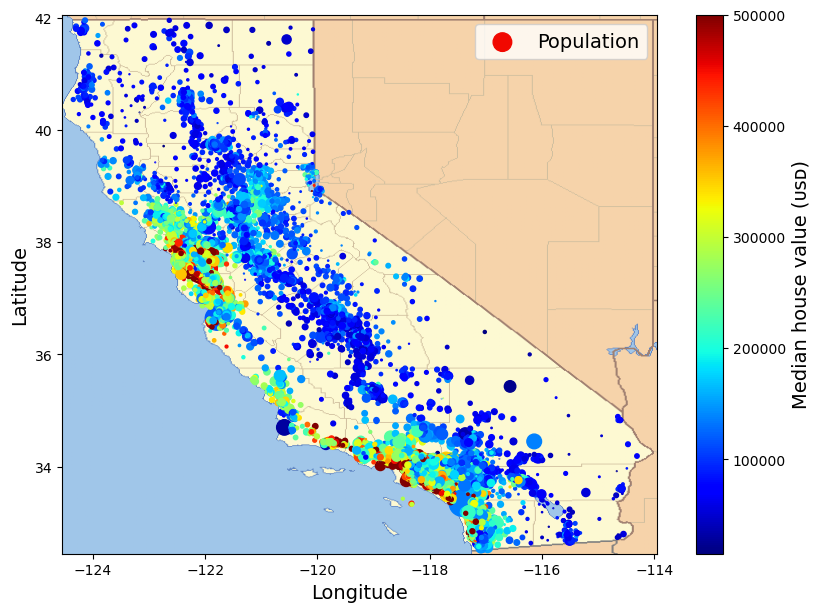

In [10]:
# Download the California image
filename = "california.png"
filepath = Path(f"my_{filename}")
if not filepath.is_file():
    homlp_root = "https://github.com/ageron/handson-mlp/raw/main/"
    url = homlp_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, filepath)

housing_renamed = housing_full.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(filepath)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

# Look for Correlations

In [11]:
corr_matrix = housing_full.corr(numeric_only=True)
# print(corr_matrix)

In [12]:
print(corr_matrix["median_house_value"].sort_values(ascending=True))

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64


The correlation coefficient ranges from –1 to 1. When it is close to 1, it
means that there is a strong positive correlation. For example, the
median house value tends to go up when the median income goes up.
When the coefficient is close to –1, it means there is a strong
negative correlation. You can see a small negative correlation between
the latitude and the median house value (i.e., prices have a slight
tendency to go down when you go north). Finally, coefficients close to
0 mean that there is no linear correlation.

# Split and Shuffle Dataset

After the dataset has been explored and we understand it's structure, we are ready to prepare the dataset for modeling. Let's split the dataset based on our task/goal.

Remember the goal is to **predict** the median house values in California districts. Hence, our target variable `y` will be `'median_house_value'` and the features set `X` will be the remaining features excluding the target.

In [13]:
from sklearn.model_selection import train_test_split

X = housing_full.drop(columns=["median_house_value"]) # get Features
y = housing_full["median_house_value"] # get Target

# split and shuffling dataset standard 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(X.shape)
print(y.shape)

(20640, 9)
(20640,)


# Data Preprocessing

Data preprocessing includes various steps such as **data cleaning** (handling missing/null values, removing duplicates, etc), **data transformations** (feature scaling, normalizing, encoding, etc.), and **data reduction** (dimensionality reduction if applicable) to make the raw data suitable for modeling or analysis. These steps ensure data accuracy, consistency, and proper structure before a machine model is ready for training.

## Data Cleaning

Remeber `'total_bedooms'` contained some missing values. Let's fill these missing values with the **median** of the `total_bedrooms`.

In [15]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy='median')

# Note: X contains a categorical and median can only be computed on numerical attributes
X_train_numerical = X_train.select_dtypes(include=[np.number])

X_train_imputed = imputer.fit_transform(X_train_numerical)

# view the computed median of each feature selected
print(imputer.statistics_)

# can convert the imputed data into a DataFrame for visual clarity
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train_numerical.columns)

print(X_train_imputed_df['total_bedrooms'].info())
X_train_imputed_df

# Note: pipeline created later will handle the preprocessing workflow

[-118.49     34.25     29.     2129.      437.     1169.      411.
    3.5246]
<class 'pandas.core.series.Series'>
RangeIndex: 16512 entries, 0 to 16511
Series name: total_bedrooms
Non-Null Count  Dtype  
--------------  -----  
16512 non-null  float64
dtypes: float64(1)
memory usage: 129.1 KB
None


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
1,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
2,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
3,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
4,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688
...,...,...,...,...,...,...,...,...
16507,-122.37,37.94,49.0,969.0,229.0,599.0,195.0,1.3167
16508,-118.38,33.89,35.0,1778.0,330.0,732.0,312.0,6.5745
16509,-119.33,36.28,16.0,2624.0,527.0,1077.0,520.0,2.1250
16510,-117.19,34.08,22.0,2467.0,555.0,1567.0,494.0,2.6536


# Handling Text and Categorical Attributes

Most machine learning models are only capable of handling numerical data, thus we may chose to convert the categorical attributes into numbers. Sckit-Learn provides various ways to encode categorical attributes.

In [16]:
from sklearn.preprocessing import OneHotEncoder

# create an instance that returns numpy array
cat_encoder = OneHotEncoder(sparse_output=False)

X_train_categorical = X_train.select_dtypes(include=[object])

X_train_cat = cat_encoder.fit_transform(X_train_categorical)

print(X_train_cat)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


# Feature Scaling and Transformations

Machine learning algorithms don’t perform well when the input numerical attributes
have very different scales. This is the case for our housing dataset. The
total number of rooms ranges from about (6 to 39,320), while the
median incomes only range from (0 to 15). Without any scaling, most
models will be biased toward ignoring the median income and
focusing more on the number of rooms. Sckit-Learn provides a few classes to ensure all attributes have the same scale.

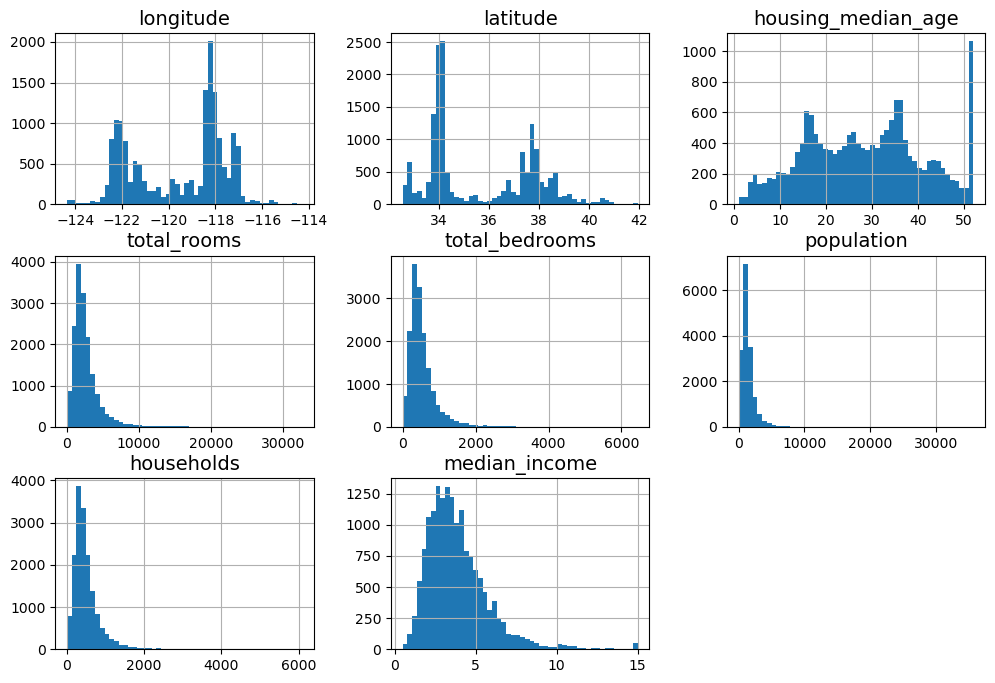

In [17]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train_imputed)

# print(X_train_scaled)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_numerical.columns)

X_train.hist(bins=50, figsize=(12, 8))

plt.show()

# Transformation Pipelines

As shown in the previous procedures there are many data transformation steps that need to
be executed in the right order. Scikit-Learn provides the **Pipeline** class to help with such sequences of transformations.

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

# define transformers
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=False)
)

# combine transformers
preprocessing = make_column_transformer(
    (numerical_pipeline, make_column_selector(dtype_include=[np.number])),
    (categorical_pipeline, make_column_selector(dtype_include=[object])),
)

# Select, Train, and Evaluate Model

Data preprocessing step is complete. Now we are ready to select and train models.

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(
    preprocessing,
    LinearRegression()
)

# train (fit) training set
lin_reg.fit(X_train, y_train)

# make predictions on test data
y_pred_lin = lin_reg.predict(X_test)

Let's now compare the predict results vs the actual results

In [20]:
print(f'Predicted Values: {y_pred_lin[:5].round(-2)}')
print(f'Actual Values:    {y_test.iloc[:5].values}')

Predicted Values: [ 40800. 264900. 384200. 299600. 248900.]
Actual Values:    [ 65600. 353400. 466700. 500001. 286100.]


Almost all values are off. Let's calculate the Root Mean Squared Error to evaluate the model's performance and understand why the predicted values may differ from the actual values.

In [21]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(y_test, y_pred_lin)
print("Linear Regression RMSE Score:", lin_rmse)

Linear Regression RMSE Score: 69791.2548561354


- **Higher RMSE**: A larger RMSE indicates that the model’s predictions are more spread out from the actual values. This means the model is making larger errors on average, hence less accurate.

- **Lower RMSE**: A smaller RMSE indicates that the model’s predictions are closer to the actual values, suggesting better predictive performance.

- **RMSE of 0**: The model's predictions are exactly correct for every data point (no error), which is typically not achievable in real-world scenarios unless the model overfits the training data.

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=42),
)

tree_reg.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
y_pred_tree = tree_reg.predict(X_test)
tree_rmse = root_mean_squared_error(y_test, y_pred_tree)
print("Decision Tree RMSE Score:", tree_rmse)

Decision Tree RMSE Score: 68306.66247492214


## Evaluation using Cross-Validation

Cross validation is an evaluation metric that serves to provide a more advanced and robust technique using **k-folds** to measure the performance of a model.

<img src="./cross_validation.png" alt="alt text" width="400" height="400">

In [24]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, X, y, 
                              scoring="neg_root_mean_squared_error", cv=10)
# print(tree_rmses)
print(pd.Series(tree_rmses).describe())

count       10.000000
mean     68649.230453
std       3150.819349
min      65286.185352
25%      66561.338291
50%      68122.517438
75%      69265.886976
max      76372.420640
dtype: float64


In [25]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmses = -cross_val_score(forest_reg, X, y,
                                scoring="neg_root_mean_squared_error", cv=10)

print(pd.Series(forest_rmses).describe())

count       10.000000
mean     48519.122540
std       2418.515926
min      44582.298545
25%      46959.554828
50%      48143.994556
75%      50067.590395
max      53256.060055
dtype: float64


In [26]:
from sklearn.svm import SVR

svr_pipeline = make_pipeline(
    preprocessing,
    SVR(),
)

svr_rmses = -cross_val_score(svr_pipeline, X, y, 
                             scoring="neg_root_mean_squared_error", cv=10)

print(pd.Series(svr_rmses).describe())

count        10.000000
mean     118109.916664
std        1469.299631
min      115923.828381
25%      117417.070513
50%      118037.958647
75%      118517.879656
max      120495.021985
dtype: float64


In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = make_pipeline(
    preprocessing,
    KNeighborsRegressor(n_neighbors=5, weights='distance'),
)

knn_rmses = -cross_val_score(knn_reg, X, y,
                             scoring="neg_root_mean_squared_error", cv=10)

print(pd.Series(knn_rmses).describe())

count       10.000000
mean     60426.173614
std       1705.571901
min      56620.038079
25%      59833.866269
50%      61109.919174
75%      61553.489303
max      62051.510446
dtype: float64


# Fine-Tune Your Model

Let's assume we have have shortlisted (3-5) promising models. Let's attempt to fine tune the model's hyperparameters for potentially enhanced performance boost. Sckit-Learn provides various **search** algorithms that can be used to find the best combination of hyperparameters values for a model.

In [28]:
from sklearn.model_selection import GridSearchCV

# define full pipeline
full_pipeline = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42),
)

# random forest hyperparameters combinations
param_grid = [
    {
        'randomforestregressor__n_estimators': [100, 200, 300],
        'randomforestregressor__max_features': [1.0, "sqrt", "log2"]
    },
]

# grid search instance for Random Forest
grid_search_forest = GridSearchCV(full_pipeline, param_grid=param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

# # Due to training time, we train only on the first 5000 instances
grid_search_forest.fit(X_train[:5000], y_train[:5000])

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'randomforestregressor__max_features': [1.0, 'sqrt', ...], 'randomforestregressor__n_estimators': [100, 200, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"


**NOTE**: Because we only searched on a subset of the training set we will see a decrease in the evaluation metric score.

In [29]:
# get best hyperparameters and best score
print("Best hyperparameters:", grid_search_forest.best_params_)
print("Best RMSE Score:", -grid_search_forest.best_score_)

Best hyperparameters: {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 300}
Best RMSE Score: 55272.84146004318


We can put the cross validation splits into a DataFrame for visual clarity.

In [30]:
cv_res = pd.DataFrame(grid_search_forest.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_randomforestregressor__max_features",
                 "param_randomforestregressor__n_estimators",
                 "split0_test_score", "split1_test_score", 
                 "split2_test_score", "mean_test_score"]]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["max_features", "n_estimators"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,max_features,n_estimators,split0,split1,split2,mean_test_rmse
8,log2,300,54407,54760,56651,55273
5,sqrt,300,54407,54760,56651,55273
3,sqrt,100,54631,54779,56445,55285
6,log2,100,54631,54779,56445,55285
4,sqrt,200,54383,54859,56643,55295


In [31]:
full_pipeline = make_pipeline(
    preprocessing,
    SVR(),
)

param_grid = [
    {
        'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]
    },
    {
        'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
    },
]

grid_search_srv = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

%time grid_search_srv.fit(X_train[:5000], y_train[:5000])

CPU times: user 52.5 s, sys: 1.77 s, total: 54.3 s
Wall time: 56.6 s


,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [10.0, 30.0, ...], 'svr__kernel': ['linear']}, {'svr__C': [1.0, 3.0, ...], 'svr__gamma': [0.01, 0.03, ...], 'svr__kernel': ['rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"


In [32]:
print("Best hyperparameters:", grid_search_srv.best_params_)
print("Best RMSE Score:", -grid_search_srv.best_score_)

Best hyperparameters: {'svr__C': 30000.0, 'svr__kernel': 'linear'}
Best RMSE Score: 69977.53366904253


Nice! Even without the full training set, we can still achieve greater performance with the right set of hyperparameters. Now lets explore `RandomizedSearchCV`.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

full_pipeline = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42),
)

param_distribs = [
    {
        'randomforestregressor__n_estimators': randint(100, 500),  # Randomly choose from 100 to 500
        'randomforestregressor__max_features': [1.0, "sqrt", "log2"],
    }
]

rnd_search_forest = RandomizedSearchCV(full_pipeline,
                                    param_distributions=param_distribs,
                                    n_iter=50, cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    random_state=42)

%time rnd_search_forest.fit(X_train[:5000], y_train[:5000])

CPU times: user 5min 5s, sys: 305 ms, total: 5min 6s
Wall time: 5min 11s


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'randomforestregressor__max_features': [1.0, 'sqrt', ...], 'randomforestregressor__n_estimators': <scipy.stats....x7f4824622900>}]"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("Best hyperparameters:", rnd_search_forest.best_params_)
print("Best RMSE Score:", -rnd_search_forest.best_score_)

Best hyperparameters: {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 487}
Best RMSE Score: 55224.72741687181


In [35]:
from scipy.stats import expon, loguniform

full_pipeline = make_pipeline(
    preprocessing,
    SVR(),
)

param_distribs = [
    {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    },
]

rnd_search_svr = RandomizedSearchCV(full_pipeline,
                                    param_distributions=param_distribs,
                                    n_iter=50, cv=3,
                                    scoring="neg_root_mean_squared_error",
                                    random_state=42)

%time rnd_search_svr.fit(X_train[:5000], y_train[:5000])

CPU times: user 57.2 s, sys: 1.43 s, total: 58.6 s
Wall time: 59.4 s


,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"[{'svr__C': <scipy.stats....x7f4824622ba0>, 'svr__gamma': <scipy.stats....x7f482ebfd090>, 'svr__kernel': ['linear', 'rbf']}]"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [36]:
print("Best hyperparameters:", rnd_search_svr.best_params_)
print("Best RMSE Score:", -rnd_search_svr.best_score_)

Best hyperparameters: {'svr__C': np.float64(157055.10989448498), 'svr__gamma': np.float64(0.26497040005002437), 'svr__kernel': 'rbf'}
Best RMSE Score: 58344.51087905464


**Summary (`GridSearchCV` vs `RandomizedSearchCV`)**

Randomized search tends to find better hyperparameters than grid search in the same amount of time. Thus quicker searches and better performance.

| Feature           | GridSearchCV                  | RandomizedSearchCV                                |
| ----------------- | ----------------------------- | ------------------------------------------------- |
| Search method     | Exhaustive (tests all combos) | Random sampling of combos                         |
| Speed             | Slower                        | Faster (especially for many parameters)           |
| Guarantee of best | Yes                           | No, approximate best                              |
| Useful for        | Small, well-defined grids     | Large or continuous search spaces                 |
| Parameter types   | Discrete lists                | Can use distributions (uniform, loguniform, etc.) |


- **GridSearchCV** = exhaustive and exact but slow.
- **RandomizedSearchCV** = faster, more flexible, often just as effective — especially for large hyperparameter spaces.

# Ensemble Methods

Another way to fine-tune a system is to try to combine the models
that perform best. The group (or “**ensemble**”) will often perform
better than the best individual model. Random forests is an ensemble of
decision tree. It performs better than an individual decision tree.
Ensemble are based on the **"Wisdom of the Crowd"** theory, stating a
large group's collective judgement is often better than the best single
judgement.

# Analyze the Final Model and Their Errors

Let's create a new pipeline that runs the previously defined preparation pipeline, and add a `SelectFromModel` transformer to select only the most important features based on a `RandomForestRegressor` before the final model.

In [39]:
from sklearn.feature_selection import SelectFromModel

params = {k.split('__')[1]: v for k, v in rnd_search_forest.best_params_.items() if k.startswith('randomforestregressor__')}

selector_pipeline = make_pipeline(
    preprocessing, # apply preprocessing
    SelectFromModel(RandomForestRegressor(random_state=42), threshold=0.005), # feature selection based on RandomForest
    RandomForestRegressor(**params), # unpack best params
)

selector_rmses = -cross_val_score(selector_pipeline, X, y,
                                  scoring="neg_root_mean_squared_error", cv=3)

pd.Series(selector_rmses).describe()

count        3.000000
mean     49629.130679
std       1355.076097
min      48825.612977
25%      48846.873427
50%      48868.133878
75%      50030.889530
max      51193.645182
dtype: float64

## Evaluate the System on the Test Set

In [40]:
final_model = rnd_search_forest.best_estimator_ # includes preprocessing

final_model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
final_predictions = final_model.predict(X_test)
final_rmses = root_mean_squared_error(y_test, final_predictions)
print("Best Model RMSE Score:", final_rmses)

Best Model RMSE Score: 50115.3944513823


Let's compute the 95% confidence interval for the test RMSE using SciPy's `bootstrap()` function.

In [42]:
from scipy.stats import bootstrap

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = bootstrap([squared_errors], rmse, confidence_level=confidence,
                        random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

In [43]:
print(f"95% CI for RMSE: ({rmse_lower:.4f}, {rmse_upper:.4f})")

95% CI for RMSE: (48063.9894, 52535.8790)


If you do a lot of hyperparameter tuning, the performance will usually
be slightly worse than what you measured using cross-validation.
That’s because your system ends up fine-tuned to perform well on the
validation data and will likely not perform as well on unknown
datasets. That’s not the case in this example since the test RMSE is
lower than the validation RMSE, but when it happens you must resist
the temptation to tweak the hyperparameters to make the numbers
look good on the test set. The improvements would be unlikely to
generalize to new data.

**NOTE**: Remeber not full training set was used during hyperparameter tuning phase, so model's performance may even decrease from what was seen in cross-validation, however the generally concept still applies.

Now is also a good time to present findings in real-world setting.

# Launch, Monitor, and Maintain the System

The most basic way to deploy your model to the production environment is to save the best model trained, transfer the file to the production environment, and load it.

In [44]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now the model is ready to be deployed to production. For example, the following code could be a script that would run in production.

In [45]:
final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing_full.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
print(predictions)

[405398.02053388 386332.94045175 378874.41478439 340635.80698152
 305779.05954825]
